In [80]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow import keras

from sklearn.feature_extraction.text import CountVectorizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
df = pd.read_csv('gdrive/MyDrive/Colab Notebooks/Projet/training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)

df.columns = ['target','id','date','flag','user','text']

In [4]:
#Visualize dataframe
df

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [5]:
print("Shape : " + str(df.shape))
print("Length : " + str(len(df)))

Shape : (1600000, 6)
Length : 1600000


In [6]:
#Let's keep only targets and text
df = df[['target','text']]
df

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [7]:
import re
def clean_tweet(text):
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text) #remove links
    text = re.sub('@[^\s]+',' ', text) #remove mentions
    text = re.sub('[\s]+', ' ', text) #remove blanks
    text = re.sub(r'#([^\s]+)', r' ', text) #remove #
    return text
df['clean_tweet'] = df.text.apply(clean_tweet)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,target,text,clean_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","- Awww, that's a bummer. You shoulda got Davi..."
1,0,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball. Managed to s...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....","no, it's not behaving at all. i'm mad. why am..."
...,...,...,...
1599995,4,Just woke up. Having no school is the best fee...,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...,Happy 38th Birthday to my boo of alll time!!! ...


In [8]:
#Remove punctiations, numbers and uppercases letters in tweets
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
def remove_punct(text):
    text = text.str.replace('[^a-zA-Z#]',' ') # keep only letters, if not a letter replace with space
    text = text.str.lower() #remove uppercases letters
    text = text.apply(lambda x: ' '.join(w for w in x.split() if w not in stopWords))
    return text
df['clean_tweet'] = remove_punct(df['clean_tweet'])
df 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,target,text,clean_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
2,0,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save rest go bounds
3,0,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",behaving mad see
...,...,...,...
1599995,4,Just woke up. Having no school is the best fee...,woke school best feeling ever
1599996,4,TheWDB.com - Very cool to hear old Walt interv...,thewdb com cool hear old walt interviews
1599997,4,Are you ready for your MoJo Makeover? Ask me f...,ready mojo makeover ask details
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...,happy th birthday boo alll time tupac amaru sh...


In [9]:
#tokenize texts
tokenized_text = df['clean_tweet'].apply(lambda x: x.split())
tokenized_text.head()

0    [awww, bummer, shoulda, got, david, carr, thir...
1    [upset, update, facebook, texting, might, cry,...
2    [dived, many, times, ball, managed, save, rest...
3              [whole, body, feels, itchy, like, fire]
4                                 [behaving, mad, see]
Name: clean_tweet, dtype: object

In [10]:
#stemming words
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_text = tokenized_text.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_text.head()

0    [awww, bummer, shoulda, got, david, carr, thir...
1    [upset, updat, facebook, text, might, cri, res...
2    [dive, mani, time, ball, manag, save, rest, go...
3               [whole, bodi, feel, itchi, like, fire]
4                                    [behav, mad, see]
Name: clean_tweet, dtype: object

In [11]:
df['tokens'] = tokenized_text
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,target,text,clean_tweet,tokens
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww bummer shoulda got david carr third day,"[awww, bummer, shoulda, got, david, carr, thir..."
1,0,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...,"[upset, updat, facebook, text, might, cri, res..."
2,0,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save rest go bounds,"[dive, mani, time, ball, manag, save, rest, go..."
3,0,my whole body feels itchy and like its on fire,whole body feels itchy like fire,"[whole, bodi, feel, itchi, like, fire]"
4,0,"@nationwideclass no, it's not behaving at all....",behaving mad see,"[behav, mad, see]"
...,...,...,...,...
1599995,4,Just woke up. Having no school is the best fee...,woke school best feeling ever,"[woke, school, best, feel, ever]"
1599996,4,TheWDB.com - Very cool to hear old Walt interv...,thewdb com cool hear old walt interviews,"[thewdb, com, cool, hear, old, walt, interview]"
1599997,4,Are you ready for your MoJo Makeover? Ask me f...,ready mojo makeover ask details,"[readi, mojo, makeov, ask, detail]"
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...,happy th birthday boo alll time tupac amaru sh...,"[happi, th, birthday, boo, alll, time, tupac, ..."


In [12]:
# now let's see how tokenized cleaned tweets look like in the dataframe
for i in range(len(tokenized_text)):
    tokenized_text[i] = ' '.join(tokenized_text[i])

df['clean_tweet_final'] = tokenized_text

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [13]:
df

,target,text,clean_tweet,tokens,clean_tweet_final
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww bummer shoulda got david carr third day,"[awww, bummer, shoulda, got, david, carr, thir...",awww bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...,"[upset, updat, facebook, text, might, cri, res...",upset updat facebook text might cri result sch...
2,0,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save rest go bounds,"[dive, mani, time, ball, manag, save, rest, go...",dive mani time ball manag save rest go bound
3,0,my whole body feels itchy and like its on fire,whole body feels itchy like fire,"[whole, bodi, feel, itchi, like, fire]",whole bodi feel itchi like fire
4,0,"@nationwideclass no, it's not behaving at all....",behaving mad see,"[behav, mad, see]",behav mad see
...,...,...,...,...,...
1599995,4,Just woke up. Having no school is the best fee...,woke school best feeling ever,"[woke, school, best, feel, ever]",woke school best feel ever
1599996,4,TheWDB.com - Very cool to hear old Walt interv...,thewdb com cool hear old walt interviews,"[thewdb, com, cool, hear, old, walt, interview]",thewdb com cool hear old walt interview
1599997,4,Are you ready for your MoJo Makeover? Ask me f...,ready mojo makeover ask details,"[readi, mojo, makeov, ask, detail]",readi mojo makeov ask detail
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...,happy th birthday boo alll time tupac amaru sh...,"[happi, th, birthday, boo, alll, time, tupac, ...",happi th birthday boo alll time tupac amaru sh...


In [183]:
# Put label = 4 to 1 for better reading
df['target'][df['target']==4]=1

# and put pos and neg in data_pos and data_neg
#data_pos_full from 800000 to 1599999
data_pos = df[df['target'] == 1]
#data_neg_full from 0 to 799999
data_neg = df[df['target'] == 0]

# for training, keep only 20000 elements of neg and pos
data_neg_test = data_neg.iloc[:int(40000)] # 20000 first neg tweets
data_pos_test = data_pos.iloc[:int(40000)] # 20000 first pos tweets



# For tests we keep only 40000 elements
data = pd.concat([data_neg_test, data_pos_test]);

data=data[['clean_tweet_final', 'target']]
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


,clean_tweet_final,target
0,awww bummer shoulda got david carr third day,0
1,upset updat facebook text might cri result sch...,0
2,dive mani time ball manag save rest go bound,0
3,whole bodi feel itchi like fire,0
4,behav mad see,0
...,...,...
839995,ofici done driver ed stuff wait june licens ri...,1
839996,thank share care glad like quot,1
839997,ok object sustain,1
839998,twittin babi girl sleep,1


In [184]:
#x = data.cleaned_tweet
x = data.clean_tweet_final # input features
y = data.target # label

In [185]:
max_len = 500
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

vocab_size = len(tokenizer.word_index)
print("Total words", vocab_size)
print("Matrix shape", sequences_matrix.shape)


Total words 33555
Matrix shape (80000, 500)


In [186]:
x_train, x_test, y_train, y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2) # create train and test data
#x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.clean_tweet_final), maxlen=400)
#x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.clean_tweet_final), maxlen=400)
#y_train = y_train.values.reshape(-1,1)
#y_test = y_test.values.reshape(-1,1)

print("x_train : " + str(x_train.shape))
print("y_train : " + str(y_train.shape))
print("x_test : " + str(x_test.shape))
print("y_test : " + str(y_test.shape))

x_train : (56000, 500)
y_train : (56000,)
x_test : (24000, 500)
y_test : (24000,)


In [187]:
def model1(): # Pour entrainer le modèle on utilise la fonction tensorflow_based_model
    inputs = Input(name='inputs',shape=[max_len])# etape 1
    layer = Embedding(2000,50,input_length=max_len)(inputs) # etape 2
    layer = LSTM(64)(layer) # etape3
    layer = Dense(256,name='FC1')(layer) # etape 4
    layer = Activation('relu')(layer) # etape 5
    layer = Dropout(0.5)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) # etape 4 encore, mais on donne seulement 1 sortie car il faut classer le tweet positif ou négatif
    layer = Activation('sigmoid')(layer) # etape 5 encore mais la fonction d'activation est sigmoid pour une seule sortie
    model = Model(inputs=inputs,outputs=layer) # Ici on obtient la sortie finale pour la classification
    return model # on retourne la valeur

In [188]:
from keras.models import Sequential
def model2():
  model = Sequential()
  inputs = Input(name='inputs',shape=[max_len])
  model.add(Embedding(2000,50,input_length=max_len))
  model.add(LSTM(64))
  model.add(Dense(512,name='FC1'))
  model.add(Activation('relu'))
  model.add(Dropout(0.75))
  model.add(Dense(256,name='FC2'))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(128,name='FC3'))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(50, activation='softmax'))
  model.add(Dense(1,name='out_layer'))
  model.add(Activation('sigmoid'))

  return model

In [237]:
def model1LSTM():
  model = Sequential()
  embedding_layer = Embedding(sequences_matrix.shape[0], 500, weights=[sequences_matrix], input_length=max_len , trainable=False)
  model.add(embedding_layer)
  model.add(LSTM(128))

  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  
  return model

In [240]:
model = model1() # on crée notre modèle
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy']) 

In [241]:
history=model.fit(x_train,y_train,batch_size=80,epochs=50, validation_split=0.1)# On entraine le modèle avec les données d'entraînement
print('Entrainement terminé !')

Epoch 1/50
630/630 [==============================] - 17s 25ms/step - loss: 0.5892 - accuracy: 0.6779 - val_loss: 0.5079 - val_accuracy: 0.7541
Epoch 2/50
630/630 [==============================] - 15s 24ms/step - loss: 0.4866 - accuracy: 0.7703 - val_loss: 0.5007 - val_accuracy: 0.7570
Epoch 3/50
630/630 [==============================] - 15s 24ms/step - loss: 0.4689 - accuracy: 0.7768 - val_loss: 0.5058 - val_accuracy: 0.7534
Epoch 4/50
630/630 [==============================] - 16s 25ms/step - loss: 0.4614 - accuracy: 0.7801 - val_loss: 0.5121 - val_accuracy: 0.7477
Epoch 5/50
630/630 [==============================] - 15s 25ms/step - loss: 0.4423 - accuracy: 0.7895 - val_loss: 0.5189 - val_accuracy: 0.7480
Epoch 6/50
630/630 [==============================] - 15s 25ms/step - loss: 0.4283 - accuracy: 0.7970 - val_loss: 0.5294 - val_accuracy: 0.7421
Epoch 7/50
630/630 [==============================] - 16s 25ms/step - loss: 0.4193 - accuracy: 0.8014 - val_loss: 0.5492 - val_accuracy:

In [242]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


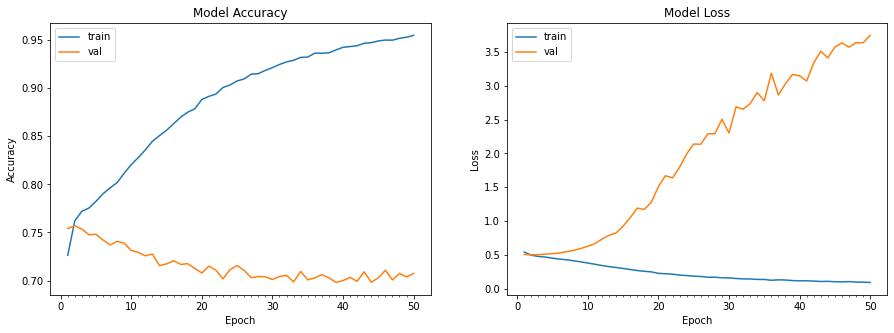

In [243]:
plot_model_history(history)

In [244]:
score = model.evaluate(x_test, y_test)
print("Accuracy :",score[1]) # précision du modèle

750/750 [==============================] - 7s 8ms/step - loss: 3.7636 - accuracy: 0.7019
Accuracy : 0.7019166946411133


In [245]:
def get_sentiment(score):
  if score < 0.5 :
    return "Negative sentiment"
  else : 
    return "Positive sentiment"

In [246]:
def predict(text):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_len)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = get_sentiment(score)

    return {"label": label, "score": float(score)}

In [247]:
predict("I loved the burger")

{'label': 'Positive sentiment', 'score': 1.0}

In [249]:
predict("Covid is a really sad period")

{'label': 'Negative sentiment', 'score': 2.4867020442798093e-07}